## Homework: Introduction

In this homework, we'll learn more about search and use Elastic Search for practice.

## Q1. Running Elastic



Run Elastic Search 8.4.3, and get the cluster information. If you run it on localhost, this is how you do it:

- curl localhost:9200


What's the version.build_hash value?



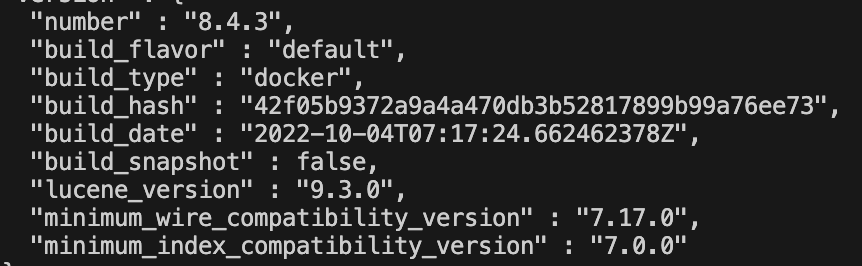m

### Answer:
- 42f05b9372a9a4a470db3b52817899b99a76ee73

## Getting the data


Now let's get the FAQ data. You can run this snippet:



In [24]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

In [25]:
documents_raw[0]

{'course': 'data-engineering-zoomcamp',
 'documents': [{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
   'section': 'General course-related questions',
   'question': 'Course - When will the course start?'},
  {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
   'section': 'General course-related questions',
   'question': 'Course - What are the prerequisites for this course?'},
  {'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the fin

In [26]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

Note that you need to have the requests library:
- pip install requests



In [27]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

## Q2. Indexing the data



Index the data in the same way as was shown in the course videos. Make the course field a keyword and the rest should be text.

Which function do you use for adding your data to elastic?

- insert
- index
- put
- add

In [28]:
from elasticsearch import Elasticsearch

In [29]:
es_client = Elasticsearch('http://localhost:9200') 

In [31]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "course-question"

es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-question'})

In [32]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

100%|█████████████████████████████████████████████████████████████| 948/948 [00:19<00:00, 48.78it/s]


### Answer:
- index

## Q3. Searching

Now let's search in our index.

We will execute a query "How do I execute a command in a running docker container?".

Use only question and text fields and give question a boost of 4, and use "type": "best_fields".

What's the score for the top ranking result?

- 94.05
- 84.05
- 74.05
- 64.05

#### Look at the _score field.



In [34]:
query = "How do I execute a command in a running docker container?"

In [ ]:
def search(query):
    boost = {'question': 4.0}

    results = index.search(
    query=query,
    filter_dict={'course':'data-engineering-zoomcamp'}, # type of filtering
    boost_dict=boost,
    num_results=5
    )

    return results

In [49]:
def elastic_search(query):
    boost = {'question': 4.0}

    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": [
                    {
                        "multi_match": {
                            "query": query,
                            "fields": ["question^4.0", "text"],  # Используем boost для поля question
                            "type": "best_fields"
                        }
                    }
                ],
                "filter": [
                    {
                        "term": {
                            "course": "data-engineering-zoomcamp"
                        }
                    }
                ]
            }
        }
    }
    
    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_score'])
    
    return result_docs

In [50]:
result_docs = elastic_search(query)

In [51]:
result_docs

[75.54128, 43.922554, 38.684105, 38.33403, 35.94081]

### Answer:
- 75.54128

## Q4. Filtering
Now let's only limit the questions to machine-learning-zoomcamp.

Return 3 results. What's the 3rd question returned by the search engine?

- How do I debug a docker container?
- How do I copy files from a different folder into docker container’s working directory?
- How do Lambda container images work?
- How can I annotate a graph?

In [54]:
def elastic_search(query):
    boost = {'question': 4.0}

    search_query = {
        "size": 3,
        "query": {
            "bool": {
                "must": [
                    {
                        "multi_match": {
                            "query": query,
                            "fields": ["question^4.0", "text"],  # Используем boost для поля question
                            "type": "best_fields"
                        }
                    }
                ],
                "filter": [
                    {
                        "term": {
                            "course": "machine-learning-zoomcamp"
                        }
                    }
                ]
            }
        }
    }
    
    response = es_client.search(index=index_name, body=search_query)

    return response
    
    # result_docs = []
    
    # for hit in response['hits']['hits']:
    #     result_docs.append(hit['_score'])
    
    # return result_docs

In [55]:
respone = elastic_search(query)

In [65]:
respone['hits']['hits'][2]

{'_index': 'course-question',
 '_id': 'wPF8aZAB4spfKTEBWOWq',
 '_score': 49.938507,
 '_source': {'text': 'You can copy files from your local machine into a Docker container using the docker cp command. Here\'s how to do it:\nIn the Dockerfile, you can provide the folder containing the files that you want to copy over. The basic syntax is as follows:\nCOPY ["src/predict.py", "models/xgb_model.bin", "./"]\t\t\t\t\t\t\t\t\t\t\tGopakumar Gopinathan',
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I copy files from a different folder into docker container’s working directory?',
  'course': 'machine-learning-zoomcamp'}}

### Answer:
- How do I copy files from a different folder into docker container’s working directory?

## Q5. Building a prompt
Now we're ready to build a prompt to send to an LLM.

Take the records returned from Elasticsearch in Q4 and use this template to build the context. Separate context entries by two linebreaks (\n\n)

In [ ]:
context_template = """
Q: {question}
A: {text}
""".strip()

Now use the context you just created along with the "How do I execute a command in a running docker container?" question to construct a prompt using the template below:

In [ ]:
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

### What's the length of the resulting prompt? (use the len function)

- 962
- 1462
- 1962
- 2462

## Q6. Tokens
When we use the OpenAI Platform, we're charged by the number of tokens we send in our prompt and receive in the response.

The OpenAI python package uses tiktoken for tokenization:

In [ ]:
pip install tiktoken

Let's calculate the number of tokens in our query:


In [ ]:
encoding = tiktoken.encoding_for_model("gpt-4o")

Use the encode function. How many tokens does our prompt have?

- 122
- 222
- 322
- 422